In [1]:
from geoband.API import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import geopandas as gpd
import seaborn as sns

import os

import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import display

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False
           
fix_font()

## 1. 수원시_112 신고이력

In [3]:
GetCompasData('SBJ_2109_001', '1', '1.수원시_112신고이력(격자_관할경계매핑).csv')

In [4]:
suwon_report = pd.read_csv('1.수원시_112신고이력(격자_관할경계매핑).csv')
suwon_report.head()

,case_type,rec_date,rec_time,arrival_date,gid,name,psname
0,비상벨,20200101,183945',NaN,다사56aa19ab,고등파출소,수원서부경찰서
1,기타_타기관,20200101,012615',20200101014135.0,다사58ab18ba,인계파출소,수원남부경찰서
2,폭력,20200101,005151',20200101005314.0,다사56bb21aa,화서문지구대,수원중부경찰서
3,소음,20200101,012608',20200101013131.0,다사57aa17ba,세류지구대,수원남부경찰서
4,분실습득,20200101,014719',NaN,다사59bb21aa,광교지구대,수원남부경찰서


In [5]:
## 원본 저장
suwon_report_orig = suwon_report.copy()

In [6]:
suwon_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223764 entries, 0 to 223763
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   case_type     223764 non-null  object
 1   rec_date      223764 non-null  int64 
 2   rec_time      223764 non-null  object
 3   arrival_date  199358 non-null  object
 4   gid           223764 non-null  object
 5   name          223764 non-null  object
 6   psname        223764 non-null  object
dtypes: int64(1), object(6)
memory usage: 12.0+ MB


arrival_date만 NaN값이 있는데 비상벨, 분실습득의 경우가 NaN인 걸로 봐서는 전부 0으로 대체해도 상관없을 것 같습다. arrival_date를 다룰 때 다시 살펴보겠습니다.

### 'case_type'

#### 수원시

In [7]:
suwon_report['case_type'].nunique()

20

In [8]:
suwon_report_case = suwon_report['case_type'].value_counts().reset_index()
suwon_report_case = suwon_report_case.rename(columns={'index': 'case_type', 'case_type': 'count'})
suwon_report_case.head()

,case_type,count
0,기타형사범,27922
1,위험방지,24658
2,상담문의,24256
3,교통사고,19906
4,시비,18226


Text(0.5, 1.0, '사례별 신고 횟수')

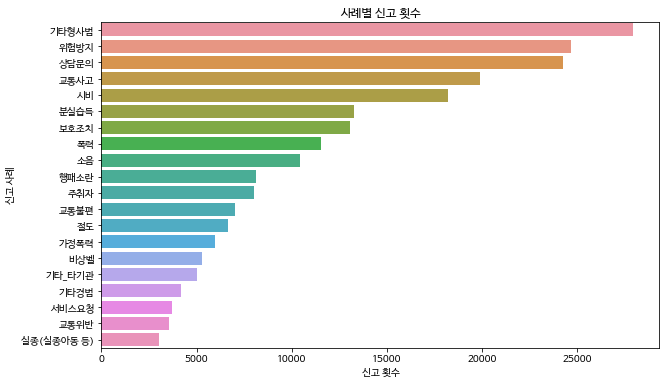

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=suwon_report_case, y='case_type', x='count', ax=ax)

ax.set_ylabel("신고 사례", fontsize=10)
ax.set_xlabel("신고 횟수", fontsize=10)
ax.set_title("사례별 신고 횟수", fontsize=12)

#### 서울, 진주, 창원

다른 3개시도의 112신고이력을 살펴보며 비교해보겠습니다.

In [10]:
GetCompasData('SBJ_2109_001', '3', '3.3개시도_112신고이력(관할경계매핑).csv')
other_3_report = pd.read_csv('3.3개시도_112신고이력(관할경계매핑).csv')

other_3_report_orig = other_3_report.copy()

other_3_report.head()

,case_type,rec_date,rec_time,arrival_date,name,psname
0,위험방지,20200101,000141',20200101001115,비봉지구대,진주경찰서
1,소음,20200101,004826',20200101004950,비봉지구대,진주경찰서
2,교통위반,20200101,014339',20200101015133,개양파출소,진주경찰서
3,위험방지,20200101,023507',20200101023915,개양파출소,진주경찰서
4,위험방지,20200101,005003',20200101005019,비봉지구대,진주경찰서


In [11]:
other_3_report['case_type'].nunique()

22

전체 3개시도의 신고 이력을 통합해서 살펴보겠습니다.

In [12]:
other_3_report_case = other_3_report['case_type'].value_counts().reset_index()
other_3_report_case = other_3_report_case.rename(columns={'index': 'case_type', 'case_type': 'count'})
other_3_report_case.head()

,case_type,count
0,기타형사범,378059
1,상담문의,247459
2,보호조치,230119
3,시비,187047
4,교통사고,158891


Text(0.5, 1.0, '사례별 신고 횟수')

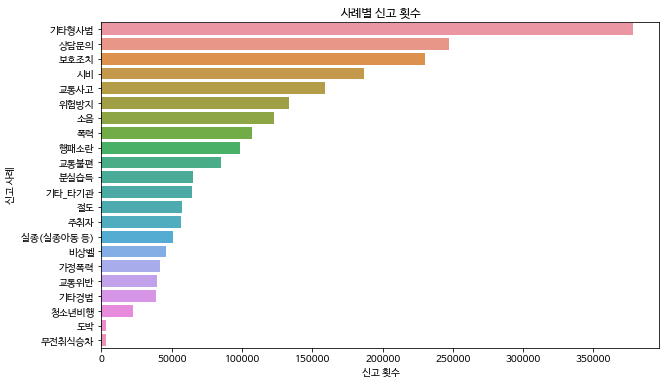

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=other_3_report_case, y='case_type', x='count', ax=ax)

ax.set_ylabel("신고 사례", fontsize=10)
ax.set_xlabel("신고 횟수", fontsize=10)
ax.set_title("사례별 신고 횟수", fontsize=12)

In [17]:
temp_df = other_3_report[(other_3_report['psname'].str.contains('창원')) | (other_3_report['psname'].str.contains('마산')) | (other_3_report['psname'].str.contains('진해'))]
temp_df = temp_df['case_type'].value_counts().reset_index()
temp_df = temp_df.rename(columns={'index': 'case_type', 'case_type': 'count'})
temp_df


,case_type,count
0,위험방지,23148
1,상담문의,18905
2,교통사고,17975
3,시비,13905
4,분실습득,13190
5,기타형사범,11445
6,주취자,11045
7,행패소란,9550
8,폭력,9251
9,교통불편,7954


In [18]:
temp_df = other_3_report[(other_3_report['psname'].str.contains('서울'))]
temp_df = temp_df['case_type'].value_counts().reset_index()
temp_df = temp_df.rename(columns={'index': 'case_type', 'case_type': 'count'})
temp_df

,case_type,count
0,기타형사범,362836
1,보호조치,224601
2,상담문의,223479
3,시비,169103
4,교통사고,134758
5,소음,117694
6,위험방지,102752
7,폭력,94897
8,행패소란,86338
9,교통불편,74344


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=other_3_report_case, y='case_type', x='count', ax=ax)

ax.set_ylabel("신고 사례", fontsize=10)
ax.set_xlabel("신고 횟수", fontsize=10)
ax.set_title("사례별 신고 횟수", fontsize=12)

In [ ]:
other_3_report_case = other_3_report['case_type'].value_counts().reset_index()
other_3_report_case = other_3_report_case.rename(columns={'index': 'case_type', 'case_type': 'count'})
other_3_report_case.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=other_3_report_case, y='case_type', x='count', ax=ax)

ax.set_ylabel("신고 사례", fontsize=10)
ax.set_xlabel("신고 횟수", fontsize=10)
ax.set_title("사례별 신고 횟수", fontsize=12)

이 경우에는 딱히 유의미한 차이를 보이고 있지 않습니다. 다른 지역에 비해 수원만이 가지는 범죄, 치안 문제를 파악해야 하므로 개별적으로 비교할 필요는 없다고 생각이 듭니다.

In [15]:
set(other_3_report['case_type'].unique()) - set(suwon_report['case_type'].unique()) 

{'도박', '무전취식승차', '청소년비행'}

오히려 수원의 경우 도박, 무전취식승차, 청소년비행의 범죄사례가 없다고 분류되어있는데 왜 그렇게 분류됐는지에 대해 생각해보는 것도 좋을 것 같습니다.

수원의 접수된 신고이력 수와 3개 시도의 평균 신고이력 수를 비교해보겠습니다. 평균 신고이력 수에 대해서는 간단하게 3으로 나누어 진행했습니다. (모두 2020년, 1년간 있었던 데이터입니다)

### 'rec_date', 'rec_time', 'arrival_date'

접수완료일자, 접수완료시각, 도착일시에 대해 알아보기 위해 datetime 자료형으로 변경하고 이에 대해 분석을 해보겠습니다.
(더 쉽게 datetime 자료형으로 바꿀 수 있는 방법을 찾아봐도 좋을 것 같습니다.)

#### 수원시 

In [16]:
suwon_report.head()

,case_type,rec_date,rec_time,arrival_date,gid,name,psname
0,비상벨,20200101,183945',NaN,다사56aa19ab,고등파출소,수원서부경찰서
1,기타_타기관,20200101,012615',20200101014135.0,다사58ab18ba,인계파출소,수원남부경찰서
2,폭력,20200101,005151',20200101005314.0,다사56bb21aa,화서문지구대,수원중부경찰서
3,소음,20200101,012608',20200101013131.0,다사57aa17ba,세류지구대,수원남부경찰서
4,분실습득,20200101,014719',NaN,다사59bb21aa,광교지구대,수원남부경찰서


In [17]:
suwon_report['rec_date_time'] = (suwon_report['rec_date'].astype(str) + suwon_report['rec_time'])
suwon_report['rec_date_time'] = suwon_report['rec_date_time'].str.replace("'", "")
suwon_report['rec_date_time'] = pd.to_datetime(suwon_report['rec_date_time'])


In [18]:
suwon_report['arrival_date'].fillna('0', inplace=True)
suwon_report['arrival_date'] = suwon_report['arrival_date'].astype(str)
suwon_report['arrival_date'] = suwon_report['arrival_date'].apply(lambda x: x[:-2])

In [19]:
suwon_report['arrival_date'] = pd.to_datetime(suwon_report['arrival_date'])

In [20]:
suwon_report.head()

,case_type,rec_date,rec_time,arrival_date,gid,name,psname,rec_date_time
0,비상벨,20200101,183945',NaT,다사56aa19ab,고등파출소,수원서부경찰서,2020-01-01 18:39:45
1,기타_타기관,20200101,012615',2020-01-01 01:41:35,다사58ab18ba,인계파출소,수원남부경찰서,2020-01-01 01:26:15
2,폭력,20200101,005151',2020-01-01 00:53:14,다사56bb21aa,화서문지구대,수원중부경찰서,2020-01-01 00:51:51
3,소음,20200101,012608',2020-01-01 01:31:31,다사57aa17ba,세류지구대,수원남부경찰서,2020-01-01 01:26:08
4,분실습득,20200101,014719',NaT,다사59bb21aa,광교지구대,수원남부경찰서,2020-01-01 01:47:19


In [21]:
suwon_report.drop(columns=['rec_date', 'rec_time'], axis=1, inplace=True)

In [22]:
suwon_report.rename(columns={"arrival_date": "arrival_date_time"}, inplace=True)
suwon_report = suwon_report[['case_type', 'rec_date_time', 'arrival_date_time', 'gid', 'name', 'psname']]
suwon_report.head()

,case_type,rec_date_time,arrival_date_time,gid,name,psname
0,비상벨,2020-01-01 18:39:45,NaT,다사56aa19ab,고등파출소,수원서부경찰서
1,기타_타기관,2020-01-01 01:26:15,2020-01-01 01:41:35,다사58ab18ba,인계파출소,수원남부경찰서
2,폭력,2020-01-01 00:51:51,2020-01-01 00:53:14,다사56bb21aa,화서문지구대,수원중부경찰서
3,소음,2020-01-01 01:26:08,2020-01-01 01:31:31,다사57aa17ba,세류지구대,수원남부경찰서
4,분실습득,2020-01-01 01:47:19,NaT,다사59bb21aa,광교지구대,수원남부경찰서


#### 신고 접수 시간(hour)

In [23]:
suwon_report['rec_hour'] = suwon_report['rec_date_time'].dt.hour

In [24]:
report_hour = suwon_report['rec_hour'].value_counts()
report_hour = report_hour.reset_index().rename(columns={"index": "hour", "rec_hour": "count"})

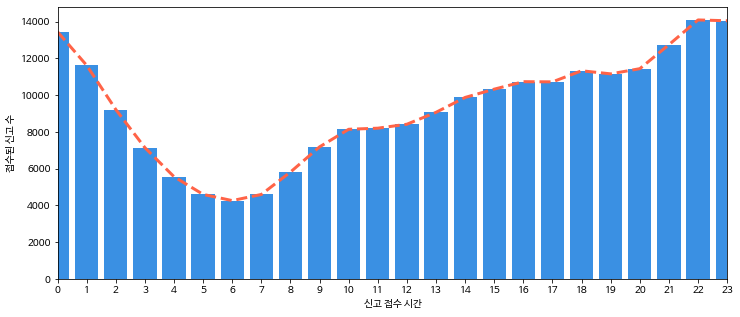

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=report_hour, x='hour', y='count', 
             color='tomato', ax=ax, linestyle='--', linewidth=3)

sns.barplot(data=report_hour, x='hour', y='count', 
             color='dodgerblue', ax=ax)

ax.set_xlim(0, 23)

ax.set_xlabel('신고 접수 시간')
ax.set_ylabel('접수된 신고 수')

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(loc)



아침부터 시작해서 점점 신고수가 늘어났다가 다시 줄어드는 모습을 확인할 수 있습니다.

In [26]:
case_hour_df = pd.pivot_table(suwon_report, index='case_type', columns=['rec_hour'], values='name', aggfunc='count')

In [27]:
case_hour_df

rec_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
case_type,,,,,,,,,,,,,,,,,,,,,
가정폭력,516,412,245,199,126,92,93,86,123,129,...,144,186,175,184,281,347,398,462,558,565
교통불편,181,109,79,64,57,115,133,274,473,336,...,376,391,433,455,610,392,331,298,372,253
교통사고,531,404,330,211,194,288,358,479,755,898,...,1183,1181,1327,1276,1482,1244,1063,980,931,689
교통위반,124,108,114,62,44,42,62,61,107,103,...,194,236,216,219,241,228,201,159,182,174
기타_타기관,241,232,182,135,109,121,133,128,184,169,...,200,209,235,247,265,266,257,346,333,270
기타경범,375,370,321,242,142,71,50,67,71,86,...,142,135,145,120,153,155,163,237,342,379
기타형사범,1448,1296,1086,808,694,537,518,539,603,849,...,1294,1390,1456,1510,1432,1403,1480,1791,1648,1616
보호조치,1230,1035,845,648,482,374,273,228,238,250,...,295,375,413,462,455,559,560,888,1066,1274
분실습득,541,461,327,252,238,214,161,225,325,468,...,819,819,876,799,792,819,716,629,784,578


Text(0.5, 0, '접수 시간')

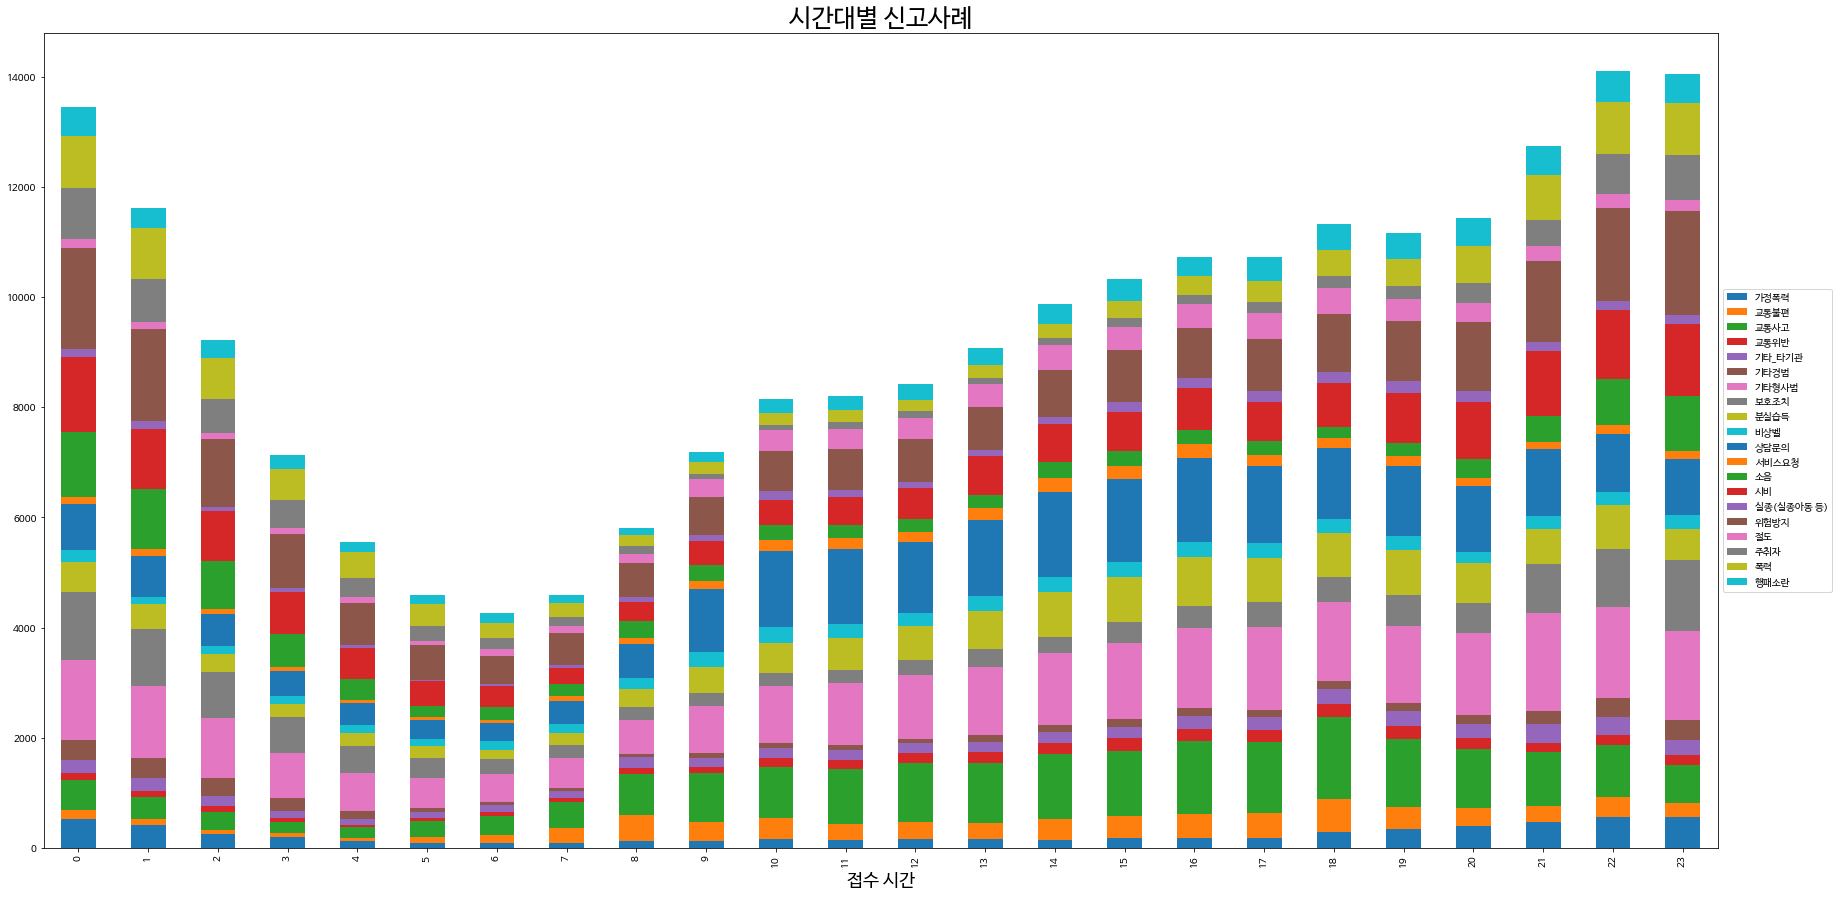

In [28]:
fig, ax = plt.subplots(figsize=(30, 15))
case_hour_df.T.plot.bar(stacked=True, legend='reverse', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('시간대별 신고사례', fontsize=25)
ax.set_xlabel("접수 시간", fontsize=18)

뚜렷하게 시간대에 따라 늘어나는 신고사례가 잘 보이지 않습니다. 다른 방법을 통해 시각화를 하는 편이 좋아보입니다.

In [29]:
suwon_report['elapsed_time'] = suwon_report['arrival_date_time'] - suwon_report['rec_date_time']

`NaT`의 경우 'arrival_date_time'이 없는 상황이였기 때문에, `NaT`로 처리됐습니다. 223760번 데이터는 'elapsed_time'이 음수로 나타나는데 이는 데이터 자체에 문제가 있는 상황입니다.

In [30]:
print(f"평균적으로 접수 후 {suwon_report['elapsed_time'].mean()}시간 안에 도착했습니다.")

평균적으로 접수 후 0 days 00:04:36.549559957시간 안에 도착했습니다.


#### 서울, 진주, 창원

In [31]:
other_3_report.head()

,case_type,rec_date,rec_time,arrival_date,name,psname
0,위험방지,20200101,000141',20200101001115,비봉지구대,진주경찰서
1,소음,20200101,004826',20200101004950,비봉지구대,진주경찰서
2,교통위반,20200101,014339',20200101015133,개양파출소,진주경찰서
3,위험방지,20200101,023507',20200101023915,개양파출소,진주경찰서
4,위험방지,20200101,005003',20200101005019,비봉지구대,진주경찰서


In [32]:
other_3_report['rec_date_time'] = (other_3_report['rec_date'].astype(str) + other_3_report['rec_time'])
other_3_report['rec_date_time'] = other_3_report['rec_date_time'].str.replace("'", "")
other_3_report['rec_date_time'] = pd.to_datetime(other_3_report['rec_date_time'])


In [33]:
other_3_report.isnull().sum()

case_type             0
rec_date              0
rec_time              0
arrival_date     252248
name                  0
psname                0
rec_date_time         0
dtype: int64

In [34]:
# fillna
# other_3_report['arrival_date'].fillna(0, inplace=True)

In [35]:
other_3_report.tail()

,case_type,rec_date,rec_time,arrival_date,name,psname,rec_date_time
2237644,폭력,20201112,031017',2.02011e+13,제기파출소,서울동대문경찰서,2020-11-12 03:10:17
2237645,보호조치,20201112,015733',2.02011e+13,불암지구대,서울노원경찰서,2020-11-12 01:57:33
2237646,보호조치,20201112,020406',2.02011e+13,중화지구대,서울중랑경찰서,2020-11-12 02:04:06
2237647,비상벨,20201112,021025',2.02011e+13,압구정파출소,서울강남경찰서,2020-11-12 02:10:25
2237648,기타_타기관,20201112,022456',2.02011e+13,신구로지구대,서울구로경찰서,2020-11-12 02:24:56


In [36]:
sample_ser = other_3_report['arrival_date']
sample_ser

0          20200101001115
1          20200101004950
2          20200101015133
3          20200101023915
4          20200101005019
                ...      
2237644       2.02011e+13
2237645       2.02011e+13
2237646       2.02011e+13
2237647       2.02011e+13
2237648       2.02011e+13
Name: arrival_date, Length: 2237649, dtype: object

In [37]:
sample_ser = sample_ser.apply(lambda x: str(x))

In [38]:
sample_ser = sample_ser.apply(lambda x: x[:14])

In [39]:
def replace_str_to_nan(x):
    if not x.isdigit():
        x = np.NaN
    return x

In [40]:
sample_ser = sample_ser.apply(lambda x: replace_str_to_nan(x))

In [41]:
other_3_report['arrival_date'] = pd.to_datetime(sample_ser)

In [42]:
other_3_report.head()

,case_type,rec_date,rec_time,arrival_date,name,psname,rec_date_time
0,위험방지,20200101,000141',2020-01-01 00:11:15,비봉지구대,진주경찰서,2020-01-01 00:01:41
1,소음,20200101,004826',2020-01-01 00:49:50,비봉지구대,진주경찰서,2020-01-01 00:48:26
2,교통위반,20200101,014339',2020-01-01 01:51:33,개양파출소,진주경찰서,2020-01-01 01:43:39
3,위험방지,20200101,023507',2020-01-01 02:39:15,개양파출소,진주경찰서,2020-01-01 02:35:07
4,위험방지,20200101,005003',2020-01-01 00:50:19,비봉지구대,진주경찰서,2020-01-01 00:50:03


In [43]:
other_3_report.rename(columns={"arrival_date": "arrival_date_time"}, inplace=True)
other_3_report = other_3_report[['case_type', 'rec_date_time', 'arrival_date_time', 'name', 'psname']]
other_3_report.head()

,case_type,rec_date_time,arrival_date_time,name,psname
0,위험방지,2020-01-01 00:01:41,2020-01-01 00:11:15,비봉지구대,진주경찰서
1,소음,2020-01-01 00:48:26,2020-01-01 00:49:50,비봉지구대,진주경찰서
2,교통위반,2020-01-01 01:43:39,2020-01-01 01:51:33,개양파출소,진주경찰서
3,위험방지,2020-01-01 02:35:07,2020-01-01 02:39:15,개양파출소,진주경찰서
4,위험방지,2020-01-01 00:50:03,2020-01-01 00:50:19,비봉지구대,진주경찰서


#### 신고 접수 시간(hour)

In [44]:
other_3_report['rec_hour'] = other_3_report['rec_date_time'].dt.hour

In [45]:
report_hour = other_3_report['rec_hour'].value_counts()
report_hour = report_hour.reset_index().rename(columns={"index": "hour", "rec_hour": "count"})

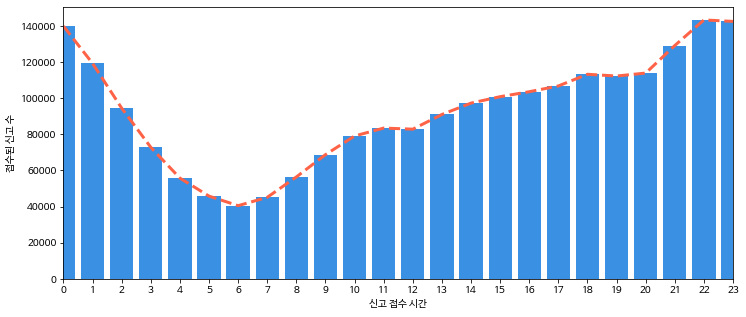

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=report_hour, x='hour', y='count', 
             color='tomato', ax=ax, linestyle='--', linewidth=3)

sns.barplot(data=report_hour, x='hour', y='count', 
             color='dodgerblue', ax=ax)

ax.set_xlim(0, 23)

ax.set_xlabel('신고 접수 시간')
ax.set_ylabel('접수된 신고 수')

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(loc)



아침부터 시작해서 점점 신고수가 늘어났다가 다시 줄어드는 모습을 확인할 수 있습니다.

In [47]:
case_hour_df = pd.pivot_table(other_3_report, index='case_type', columns=['rec_hour'], values='name', aggfunc='count')

In [48]:
case_hour_df

rec_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
case_type,,,,,,,,,,,,,,,,,,,,,
가정폭력,3437,2600,1754,1240,851,670,544,697,880,1113,...,1203,1233,1213,1327,1736,2236,2762,3396,3918,3814
교통불편,1404,1056,875,720,575,905,1512,2834,4636,4269,...,4924,4804,5303,6478,7693,5772,3968,3378,3191,2016
교통사고,4838,3742,2715,2149,2015,2379,2921,3850,6100,6864,...,9378,9428,9766,10485,11559,10029,7983,7901,6822,5558
교통위반,1630,1279,986,837,592,591,663,927,1203,1404,...,1938,2061,2271,2629,2922,2468,2054,2094,2051,1902
기타_타기관,2733,2141,1716,1489,1279,1393,1437,1747,2278,2424,...,3057,3084,3334,3415,3725,3672,3467,3753,3591,3091
기타경범,2767,2483,2100,1451,925,626,474,544,801,962,...,1725,1811,1831,1793,1715,1727,1853,2283,2727,2711
기타형사범,21012,18175,15114,12455,9568,7902,6691,7211,8759,11595,...,17787,18814,18803,18910,19239,19218,19847,21035,23252,22035
도박,154,126,81,36,38,28,9,6,6,8,...,197,332,321,272,209,221,342,311,296,239
무전취식승차,387,433,355,261,175,155,89,47,26,28,...,52,35,44,45,66,92,130,193,287,317


Text(0.5, 0, '접수 시간')

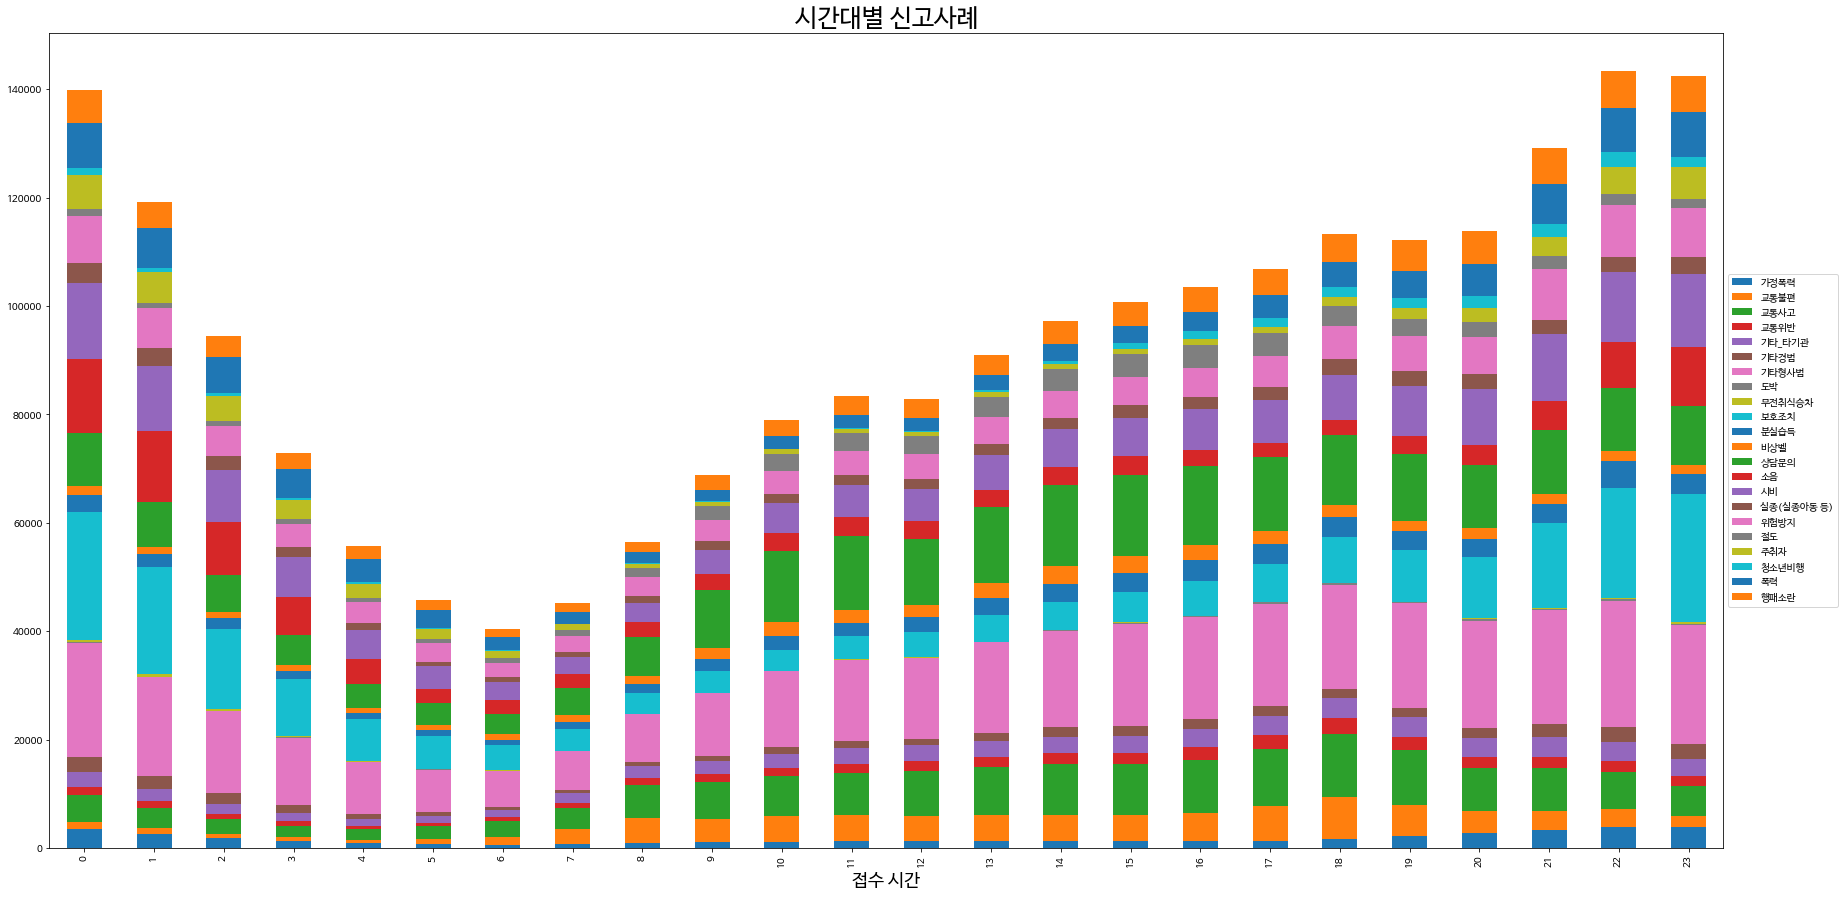

In [49]:
fig, ax = plt.subplots(figsize=(30, 15))
case_hour_df.T.plot.bar(stacked=True, legend='reverse', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('시간대별 신고사례', fontsize=25)
ax.set_xlabel("접수 시간", fontsize=18)

In [50]:
other_3_report['elapsed_time'] = other_3_report['arrival_date_time'] - other_3_report['rec_date_time']

In [51]:
other_3_report

,case_type,rec_date_time,arrival_date_time,name,psname,rec_hour,elapsed_time
0,위험방지,2020-01-01 00:01:41,2020-01-01 00:11:15,비봉지구대,진주경찰서,0,0 days 00:09:34
1,소음,2020-01-01 00:48:26,2020-01-01 00:49:50,비봉지구대,진주경찰서,0,0 days 00:01:24
2,교통위반,2020-01-01 01:43:39,2020-01-01 01:51:33,개양파출소,진주경찰서,1,0 days 00:07:54
3,위험방지,2020-01-01 02:35:07,2020-01-01 02:39:15,개양파출소,진주경찰서,2,0 days 00:04:08
4,위험방지,2020-01-01 00:50:03,2020-01-01 00:50:19,비봉지구대,진주경찰서,0,0 days 00:00:16
...,...,...,...,...,...,...,...
2237644,폭력,2020-11-12 03:10:17,2020-11-12 03:14:41,제기파출소,서울동대문경찰서,3,0 days 00:04:24
2237645,보호조치,2020-11-12 01:57:33,2020-11-12 01:59:30,불암지구대,서울노원경찰서,1,0 days 00:01:57
2237646,보호조치,2020-11-12 02:04:06,2020-11-12 02:09:45,중화지구대,서울중랑경찰서,2,0 days 00:05:39
2237647,비상벨,2020-11-12 02:10:25,2020-11-12 02:13:21,압구정파출소,서울강남경찰서,2,0 days 00:02:56


In [52]:
print(f"평균적으로 접수 후 {other_3_report['elapsed_time'].mean()}시간 안에 도착했습니다.")

평균적으로 접수 후 0 days 00:04:41.896529시간 안에 도착했습니다.


## 수원시 시간대별 유동인구

In [3]:
GetCompasData('SBJ_2109_001', '4', '4.수원시_시간대별_유동인구(2020).csv')

In [88]:
suwon_floating = pd.read_csv('4.수원시_시간대별_유동인구(2020).csv')

In [89]:
suwon_floating.head()

,STD_YM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,...,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,lon,lat
0,202001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,126.929668,37.270151
1,202001,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.04,...,0.05,0.05,0.07,0.07,0.05,0.05,0.05,0.04,126.930229,37.270604
2,202001,0.05,0.05,0.04,0.02,0.02,0.04,0.04,0.04,0.05,...,0.11,0.11,0.12,0.12,0.11,0.12,0.11,0.09,126.930188,37.276012
3,202001,0.02,0.02,0.02,0.00,0.00,0.00,0.02,0.02,0.02,...,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.02,126.931363,37.269708
4,202001,0.02,0.02,0.00,0.00,0.00,0.02,0.02,0.02,0.07,...,0.07,0.07,0.09,0.09,0.07,0.05,0.05,0.04,126.931319,37.275567


In [5]:
time_column = ['TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 
               'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 
               'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 
               'TMST_21', 'TMST_22', 'TMST_23']

suwon_floating_avg = suwon_floating.groupby('STD_YM')[time_column].mean()
suwon_floating_avg

,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,...,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23
STD_YM,,,,,,,,,,,,,,,,,,,,,
202001,2.822951,2.216161,1.785670,1.575934,1.573171,2.063320,3.380596,5.608559,7.792463,7.358910,...,8.542809,8.739696,9.042981,9.781976,10.481547,8.697818,6.969570,6.114952,5.257215,3.981360
202002,2.598108,2.068977,1.685620,1.501352,1.502702,1.997840,3.293451,5.591865,7.604789,6.716227,...,7.342140,7.493009,7.797047,8.642852,9.570697,8.067496,6.329904,5.490372,4.664760,3.596560
202003,2.380008,1.968100,1.622435,1.461451,1.463059,1.978841,3.235328,5.446911,7.184852,6.251134,...,7.057071,7.207578,7.429955,8.280302,9.274059,7.562956,6.006149,5.100972,4.178437,3.205446
202004,2.500752,2.005123,1.623777,1.457058,1.469786,2.034328,3.466605,5.866957,7.624070,6.849710,...,7.738169,7.949018,8.234126,9.228818,10.089377,8.361875,6.600664,5.608489,4.649011,3.622901
202005,2.657003,2.068353,1.626655,1.472925,1.457109,2.046021,3.485570,5.939493,7.673699,7.023057,...,7.943589,8.212353,8.582260,9.570720,10.296607,8.691137,7.037110,6.085082,5.118423,3.968917
202006,2.681176,2.290560,1.649762,1.537222,1.498719,2.214013,3.883892,6.750040,8.901349,7.583335,...,7.716476,7.975661,8.479073,9.779095,10.735648,9.026027,7.262495,6.273368,5.274754,3.909584
202007,2.722702,2.396048,1.655415,1.538511,1.499063,2.151922,3.773891,6.610542,8.732371,7.475918,...,7.705744,8.012188,8.518857,9.734052,10.659067,8.872761,7.144527,6.205711,5.216912,3.893567
202008,2.632826,2.377411,1.673442,1.559432,1.491146,2.059304,3.493923,5.917556,7.466930,6.774144,...,7.454848,7.591201,8.049809,8.923620,9.742105,8.279889,6.701196,5.730463,4.760352,3.608552
202009,2.696404,2.387780,1.715366,1.655198,1.591290,2.242346,3.735489,6.398653,8.084017,7.149660,...,7.732511,8.032133,8.506946,9.554573,10.233975,8.638856,6.956822,5.970591,4.705475,3.581400


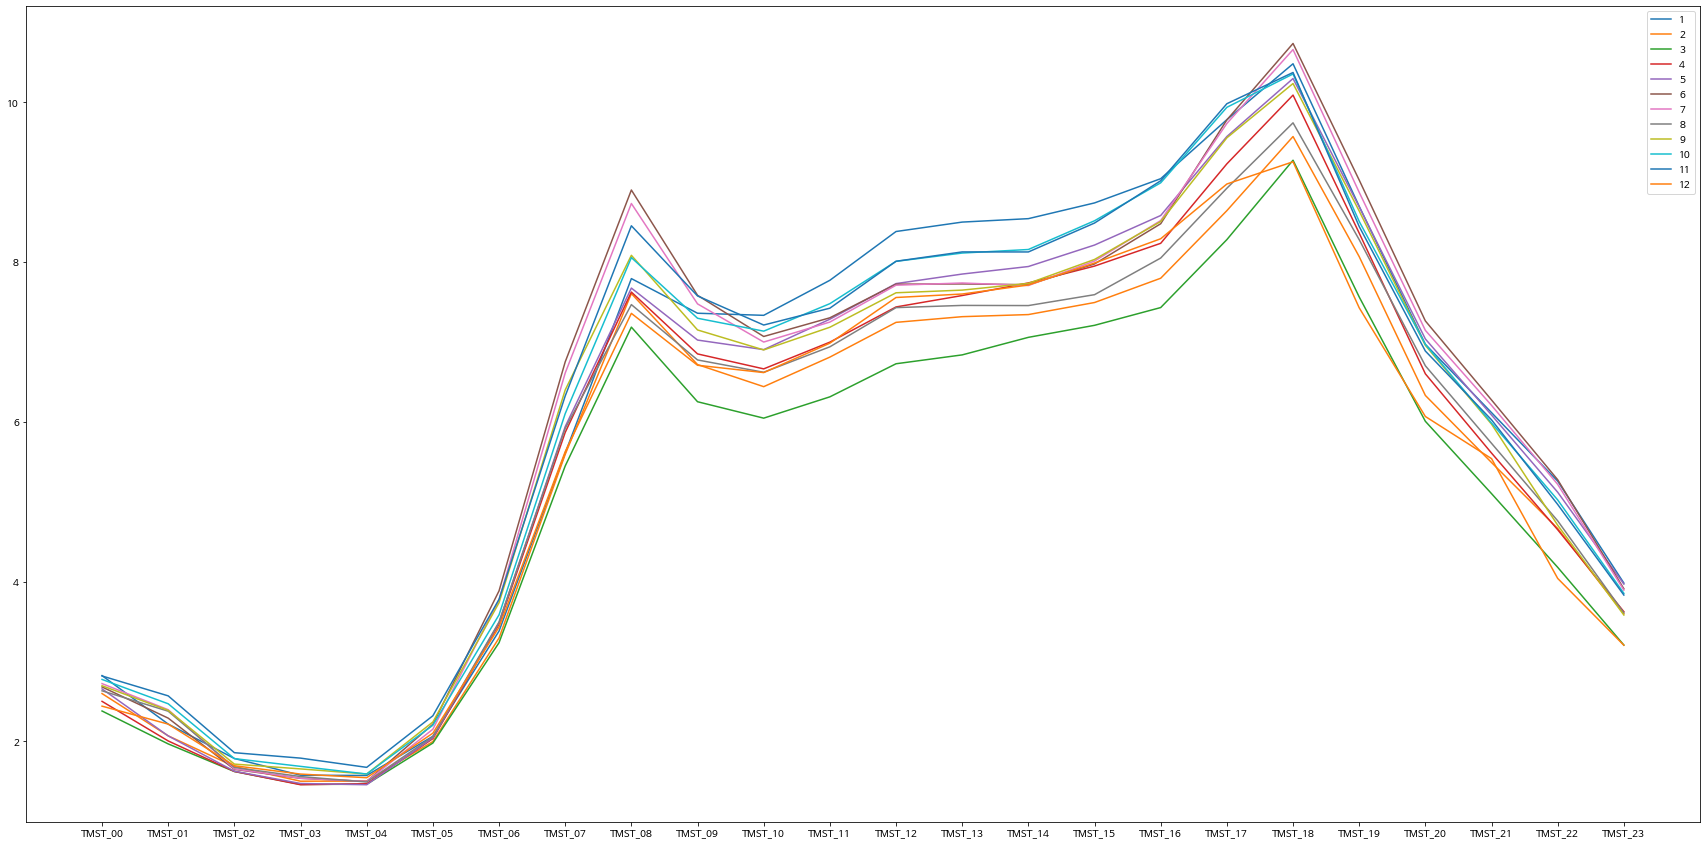

In [6]:
fig, ax = plt.subplots(figsize=(30, 15))
for i in range(0, 12):
    ax.plot(time_column, suwon_floating_avg.iloc[i, :].to_numpy(), label=str(i+1))

ax.legend()

위도, 경도 정보를 살리면 지역별로 차이를 찾을 수 있을 것 같습니다. 다만 측정소의 위치가 얼마 차이가 나지 않는 경우도 있어 효율적인 처리방법에 대해 생각해봐야할 것 같습니다.

시간대별 유동인구를 월별로 파악해봤습니다. 전체적으로 높이의 차이는 있지만 유사한 패턴을 보이고 있습니다.

항상 유동인구가 적은 00~04시 사이에는 어떤 범죄가 많은지 또 유동인구가 늘어나는 07-09, 16-19시에는 어떤 범죄가 많이 일어나는 지에 대해 시간대별로 알아보면 좋을 것 같습니다.

관련해서 시간대별로 시각화 하는 방법에 대해서도 생각봐야할 것 같습니다.

## 수원시 성연령별 유동인구

In [7]:
GetCompasData('SBJ_2109_001', '5', '5.수원시_성연령별_유동인구(2020).csv')

In [8]:
gender_floating = pd.read_csv('5.수원시_성연령별_유동인구(2020).csv')
gender_floating.head()

,STD_YM,MAN_FLOW_POP_CNT_10G,MAN_FLOW_POP_CNT_20G,MAN_FLOW_POP_CNT_30G,MAN_FLOW_POP_CNT_40G,MAN_FLOW_POP_CNT_50G,MAN_FLOW_POP_CNT_60GU,WMAN_FLOW_POP_CNT_10G,WMAN_FLOW_POP_CNT_20G,WMAN_FLOW_POP_CNT_30G,WMAN_FLOW_POP_CNT_40G,WMAN_FLOW_POP_CNT_50G,WMAN_FLOW_POP_CNT_60GU,lon,lat
0,202001,0.00,0.02,0.04,0.04,0.04,0.02,0.00,0.00,0.04,0.04,0.04,0.02,126.929668,37.270151
1,202001,0.06,0.08,0.06,0.10,0.09,0.08,0.06,0.06,0.07,0.12,0.09,0.10,126.930229,37.270604
2,202001,0.09,0.12,0.10,0.23,0.18,0.15,0.11,0.09,0.09,0.25,0.23,0.13,126.930188,37.276012
3,202001,0.04,0.04,0.04,0.08,0.06,0.02,0.04,0.04,0.04,0.08,0.06,0.02,126.931363,37.269708
4,202001,0.04,0.06,0.09,0.12,0.14,0.15,0.02,0.04,0.07,0.14,0.14,0.09,126.931319,37.275567


In [9]:
gender_floating.describe()

,STD_YM,MAN_FLOW_POP_CNT_10G,MAN_FLOW_POP_CNT_20G,MAN_FLOW_POP_CNT_30G,MAN_FLOW_POP_CNT_40G,MAN_FLOW_POP_CNT_50G,MAN_FLOW_POP_CNT_60GU,WMAN_FLOW_POP_CNT_10G,WMAN_FLOW_POP_CNT_20G,WMAN_FLOW_POP_CNT_30G,WMAN_FLOW_POP_CNT_40G,WMAN_FLOW_POP_CNT_50G,WMAN_FLOW_POP_CNT_60GU,lon,lat
count,416409.000000,416409.000000,416409.00000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000,416409.000000
mean,202006.670776,4.340546,9.70562,16.011895,19.643709,17.095237,13.553252,4.488330,8.741531,11.083487,13.157745,11.517923,9.430370,127.011837,37.275911
std,3.454350,9.849284,21.36311,36.261147,43.249184,30.220777,24.549448,10.362928,21.849758,25.585841,26.510845,21.593071,19.008153,0.036937,0.023129
min,202001.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.927348,37.224588
25%,202004.000000,0.260000,0.76000,1.360000,1.800000,1.700000,1.270000,0.250000,0.600000,0.830000,1.050000,0.990000,0.740000,126.982415,37.257584
50%,202007.000000,1.380000,3.67000,6.270000,8.090000,7.550000,5.880000,1.380000,3.030000,3.990000,5.110000,4.770000,3.670000,127.013764,37.275114
75%,202010.000000,4.260000,10.31000,17.360000,21.860000,19.900000,15.560000,4.370000,8.780000,11.460000,14.460000,13.070000,10.270000,127.042274,37.293579
max,202012.000000,462.110000,909.25000,1875.170000,2365.730000,849.490000,762.680000,531.450000,960.020000,1378.350000,1008.850000,616.940000,622.420000,127.089136,37.350775


In [10]:
using_cols = list(gender_floating.columns)[1:-2]
gender_floating_avg = gender_floating.groupby('STD_YM')[using_cols].mean()
gender_floating_avg

,MAN_FLOW_POP_CNT_10G,MAN_FLOW_POP_CNT_20G,MAN_FLOW_POP_CNT_30G,MAN_FLOW_POP_CNT_40G,MAN_FLOW_POP_CNT_50G,MAN_FLOW_POP_CNT_60GU,WMAN_FLOW_POP_CNT_10G,WMAN_FLOW_POP_CNT_20G,WMAN_FLOW_POP_CNT_30G,WMAN_FLOW_POP_CNT_40G,WMAN_FLOW_POP_CNT_50G,WMAN_FLOW_POP_CNT_60GU
STD_YM,,,,,,,,,,,,
202001,4.591373,10.236533,16.197728,19.895306,17.789200,14.558340,4.858003,9.184693,11.692280,14.012752,12.447710,10.336237
202002,3.717992,9.238162,15.363999,18.849158,16.743596,13.092876,3.866026,8.184479,10.232727,12.250171,10.953136,8.695907
202003,3.198505,8.575841,14.829133,18.234343,16.056698,12.537353,3.314375,7.652900,9.599002,11.402458,10.409720,8.300668
202004,3.728154,9.256478,15.974411,19.666246,17.133421,13.608960,3.831274,8.353972,10.718671,12.678107,11.408877,9.243458
202005,4.179156,9.736951,16.265778,19.879341,17.380861,14.018937,4.285627,8.768270,11.305068,13.311328,11.873153,9.801117
202006,4.516545,9.956213,16.891297,20.904826,17.975620,14.168372,4.577088,9.063045,11.599451,13.836101,12.080373,9.828293
202007,4.674204,9.980497,16.663647,20.568243,17.637770,13.832861,4.739562,9.162731,11.582523,13.789388,11.920436,9.690192
202008,4.374471,9.681792,15.635712,18.922663,16.530832,12.951124,4.499163,8.658590,10.682379,12.629308,11.027795,9.009254
202009,4.454339,9.829791,16.361112,20.050791,17.201621,13.616982,4.573220,8.908727,11.329123,13.337691,11.564869,9.502566


In [11]:
tmp_gender_floating_avg = gender_floating_avg.reset_index()
tmp_gender_floating_avg

,STD_YM,MAN_FLOW_POP_CNT_10G,MAN_FLOW_POP_CNT_20G,MAN_FLOW_POP_CNT_30G,MAN_FLOW_POP_CNT_40G,MAN_FLOW_POP_CNT_50G,MAN_FLOW_POP_CNT_60GU,WMAN_FLOW_POP_CNT_10G,WMAN_FLOW_POP_CNT_20G,WMAN_FLOW_POP_CNT_30G,WMAN_FLOW_POP_CNT_40G,WMAN_FLOW_POP_CNT_50G,WMAN_FLOW_POP_CNT_60GU
0,202001,4.591373,10.236533,16.197728,19.895306,17.789200,14.558340,4.858003,9.184693,11.692280,14.012752,12.447710,10.336237
1,202002,3.717992,9.238162,15.363999,18.849158,16.743596,13.092876,3.866026,8.184479,10.232727,12.250171,10.953136,8.695907
2,202003,3.198505,8.575841,14.829133,18.234343,16.056698,12.537353,3.314375,7.652900,9.599002,11.402458,10.409720,8.300668
3,202004,3.728154,9.256478,15.974411,19.666246,17.133421,13.608960,3.831274,8.353972,10.718671,12.678107,11.408877,9.243458
4,202005,4.179156,9.736951,16.265778,19.879341,17.380861,14.018937,4.285627,8.768270,11.305068,13.311328,11.873153,9.801117
5,202006,4.516545,9.956213,16.891297,20.904826,17.975620,14.168372,4.577088,9.063045,11.599451,13.836101,12.080373,9.828293
6,202007,4.674204,9.980497,16.663647,20.568243,17.637770,13.832861,4.739562,9.162731,11.582523,13.789388,11.920436,9.690192
7,202008,4.374471,9.681792,15.635712,18.922663,16.530832,12.951124,4.499163,8.658590,10.682379,12.629308,11.027795,9.009254
8,202009,4.454339,9.829791,16.361112,20.050791,17.201621,13.616982,4.573220,8.908727,11.329123,13.337691,11.564869,9.502566
9,202010,5.027359,10.179430,16.282079,19.799440,17.080778,13.770009,5.312343,9.403942,11.821313,13.914602,11.852202,9.914644


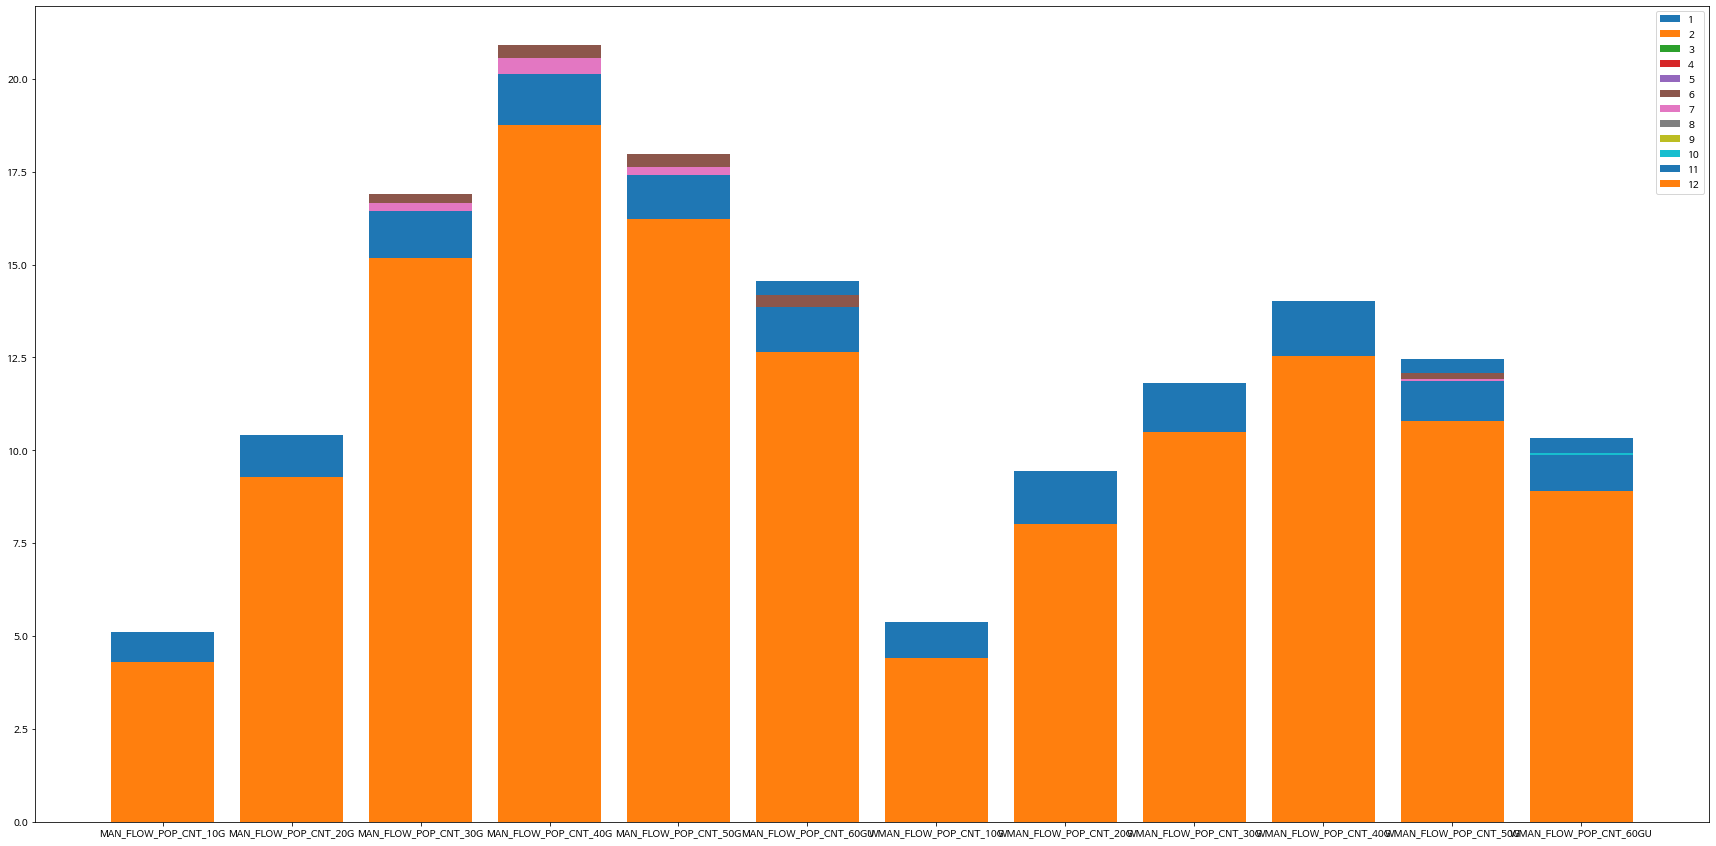

In [12]:
fig, ax = plt.subplots(figsize=(30, 15))
for i in range(0, 12):
    ax.bar(using_cols, gender_floating_avg.iloc[i, :].to_numpy(), label=str(i+1))

ax.legend()

DataFrame 다시 만들어보기.
- [ ] hue로 관측날짜랑 성별 넣어서 시각화 간단하게 가능하게 만들어보기

시각화가 잘 되지는 않았지만 전반적으로 30~50대가 유동인구의 많은 부분을 차지하고 있음을 알 수는 있었다.

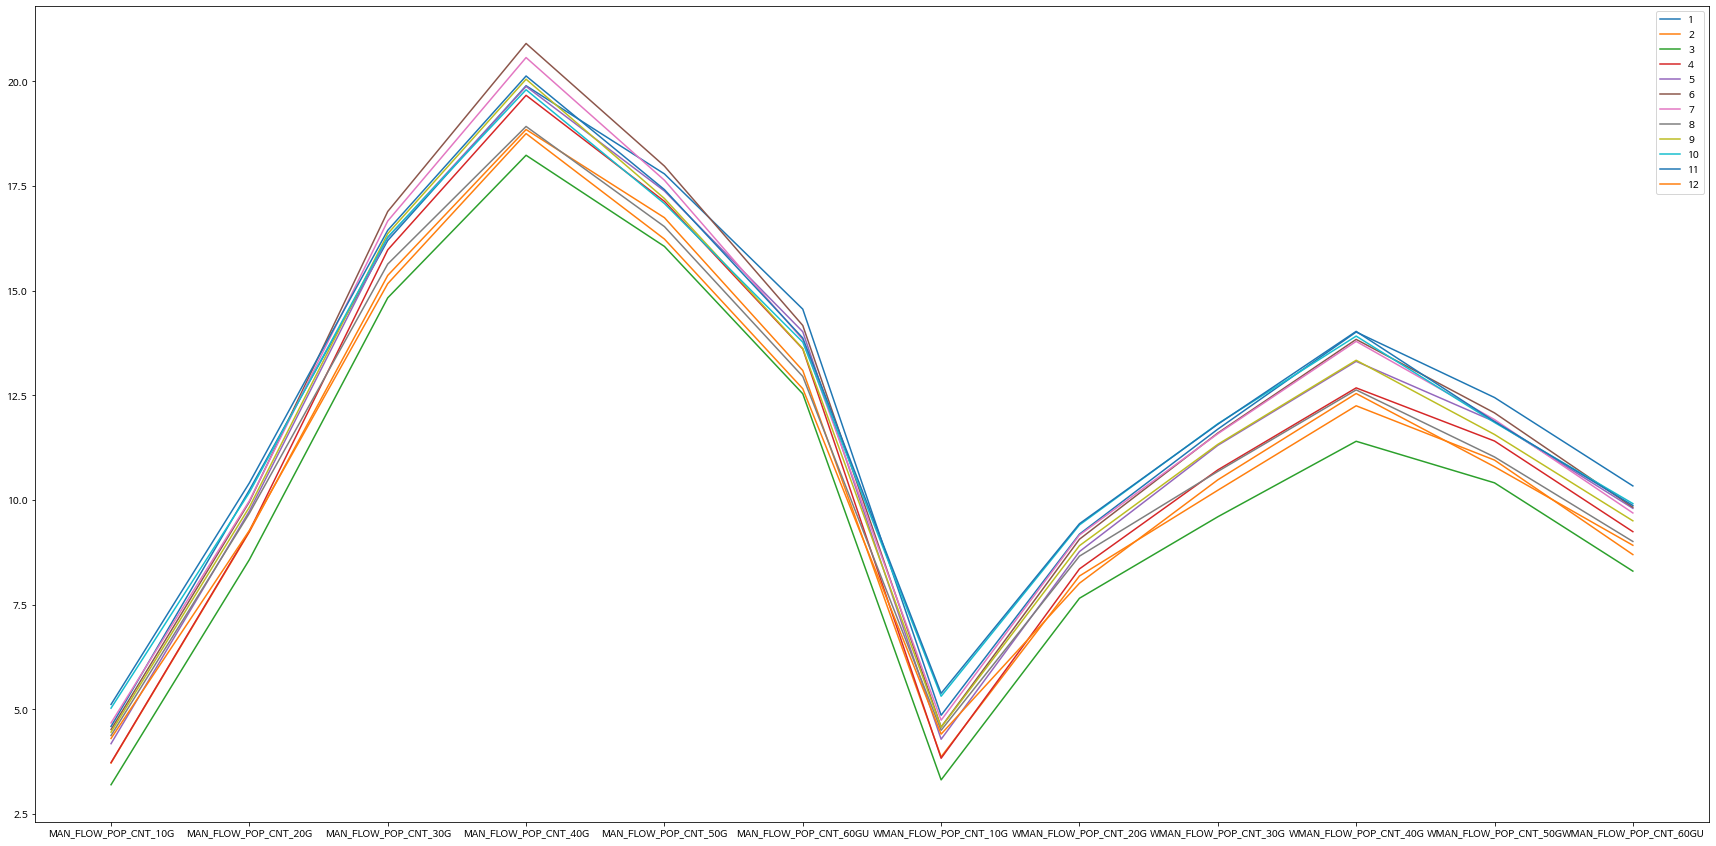

In [13]:
fig, ax = plt.subplots(figsize=(30, 15))
for i in range(0, 12):
    ax.plot(using_cols, gender_floating_avg.iloc[i, :].to_numpy(), label=str(i+1))

ax.legend()

각 월 별로 전체적인 흐름이 같으므로 위도, 경도 별로 평균을 내도 분포의 특성을 계속 유지할 수 있을 것 같습니다

In [14]:
loc_gender_floating = gender_floating.groupby(['lat', 'lon'])[using_cols].mean()
loc_gender_floating

,,MAN_FLOW_POP_CNT_10G,MAN_FLOW_POP_CNT_20G,MAN_FLOW_POP_CNT_30G,MAN_FLOW_POP_CNT_40G,MAN_FLOW_POP_CNT_50G,MAN_FLOW_POP_CNT_60GU,WMAN_FLOW_POP_CNT_10G,WMAN_FLOW_POP_CNT_20G,WMAN_FLOW_POP_CNT_30G,WMAN_FLOW_POP_CNT_40G,WMAN_FLOW_POP_CNT_50G,WMAN_FLOW_POP_CNT_60GU
lat,lon,,,,,,,,,,,,
37.224588,127.021879,0.267500,0.855833,1.295833,1.840833,1.899167,1.805000,0.285833,0.671667,0.640833,0.859167,0.918333,0.980833
37.225489,127.021873,0.086667,0.191667,0.430000,0.608333,0.639167,0.463333,0.107500,0.097500,0.221667,0.252500,0.235000,0.217500
37.225942,127.022434,0.010000,0.137500,0.112500,0.405000,0.222500,0.187500,0.020000,0.050000,0.052500,0.072500,0.072500,0.082500
37.225944,127.022998,2.240833,5.218333,7.099167,9.419167,9.526667,10.421667,2.562500,4.536667,3.870833,4.683333,4.925833,5.922500
37.226393,127.022431,0.183333,0.535000,0.763333,1.240000,1.346667,1.178333,0.168333,0.470000,0.420000,0.633333,0.698333,0.648333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37.350317,127.018260,0.010000,0.022500,0.042500,0.122500,0.272500,0.292500,0.000000,0.015000,0.027500,0.077500,0.162500,0.112500
37.350326,127.020518,0.137500,0.380000,0.526250,1.107500,2.502500,3.068750,0.090000,0.306250,0.345000,0.741250,1.557500,1.252500
37.350329,127.021083,0.050000,0.138750,0.235000,0.572500,1.472500,1.733750,0.036250,0.118750,0.135000,0.392500,0.866250,0.678750


In [15]:
loc_gender_floating.reset_index()

,lat,lon,MAN_FLOW_POP_CNT_10G,MAN_FLOW_POP_CNT_20G,MAN_FLOW_POP_CNT_30G,MAN_FLOW_POP_CNT_40G,MAN_FLOW_POP_CNT_50G,MAN_FLOW_POP_CNT_60GU,WMAN_FLOW_POP_CNT_10G,WMAN_FLOW_POP_CNT_20G,WMAN_FLOW_POP_CNT_30G,WMAN_FLOW_POP_CNT_40G,WMAN_FLOW_POP_CNT_50G,WMAN_FLOW_POP_CNT_60GU
0,37.224588,127.021879,0.267500,0.855833,1.295833,1.840833,1.899167,1.805000,0.285833,0.671667,0.640833,0.859167,0.918333,0.980833
1,37.225489,127.021873,0.086667,0.191667,0.430000,0.608333,0.639167,0.463333,0.107500,0.097500,0.221667,0.252500,0.235000,0.217500
2,37.225942,127.022434,0.010000,0.137500,0.112500,0.405000,0.222500,0.187500,0.020000,0.050000,0.052500,0.072500,0.072500,0.082500
3,37.225944,127.022998,2.240833,5.218333,7.099167,9.419167,9.526667,10.421667,2.562500,4.536667,3.870833,4.683333,4.925833,5.922500
4,37.226393,127.022431,0.183333,0.535000,0.763333,1.240000,1.346667,1.178333,0.168333,0.470000,0.420000,0.633333,0.698333,0.648333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38117,37.350317,127.018260,0.010000,0.022500,0.042500,0.122500,0.272500,0.292500,0.000000,0.015000,0.027500,0.077500,0.162500,0.112500
38118,37.350326,127.020518,0.137500,0.380000,0.526250,1.107500,2.502500,3.068750,0.090000,0.306250,0.345000,0.741250,1.557500,1.252500
38119,37.350329,127.021083,0.050000,0.138750,0.235000,0.572500,1.472500,1.733750,0.036250,0.118750,0.135000,0.392500,0.866250,0.678750
38120,37.350768,127.018257,0.075000,0.195000,0.277500,0.492500,1.070000,1.372500,0.057500,0.182500,0.185000,0.337500,0.697500,0.670000


In [16]:
loc_gender_floating['sum_float'] = loc_gender_floating[using_cols].sum(axis=1)

In [17]:
loc_gender_floating = loc_gender_floating.reset_index()
loc_gender_floating = loc_gender_floating[['lat', 'lon', 'sum_float']]
loc_gender_floating

,lat,lon,sum_float
0,37.224588,127.021879,12.320833
1,37.225489,127.021873,3.550833
2,37.225942,127.022434,1.425000
3,37.225944,127.022998,70.427500
4,37.226393,127.022431,8.285000
...,...,...,...
38117,37.350317,127.018260,1.157500
38118,37.350326,127.020518,12.015000
38119,37.350329,127.021083,6.430000
38120,37.350768,127.018257,5.612500


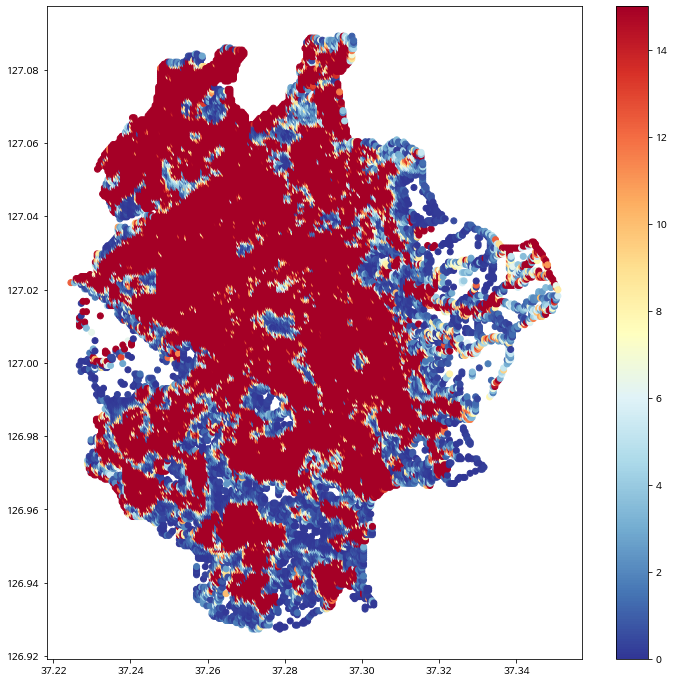

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))
t = ax.scatter(x=loc_gender_floating['lat'], y=loc_gender_floating['lon'], c=loc_gender_floating['sum_float'], vmin=0, vmax=15, cmap=plt.cm.RdYlBu_r)
plt.colorbar(t, ax=ax)

### 수원시 요일별 유동인구

SKIP

### 수원시_노숙인자활시설현황

In [26]:
import requests
import json
import os
import math
import time
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

from shapely.geometry import mapping, shape, Point, Polygon, LineString
from folium import plugins
from folium.plugins import MarkerCluster, HeatMap

In [19]:
GetCompasData('SBJ_2109_001', '13', '13.수원시_노숙인자활시설현황.csv')
suwon_rehab = pd.read_csv('13.수원시_노숙인자활시설현황.csv')

In [20]:
suwon_rehab.head()

,fac_nm,road_addr,jibun_addr,lon,lat,capacity,phone_num,base_date
0,해뜨는집,"경기도 수원시 장안구 수성로 275번길 130, 2층(정자동)",NaN,126.998741,37.295702,20,031-257-3015,2020-04-01
1,희망의쉼터,경기도 수원시 권선구 평동로 77번길 38-9(평동),NaN,126.991822,37.258268,20,031-296-4740,2020-04-01
2,마중물비전센터,경기도 수원시 팔달구 향교로 137번길 37(교동),NaN,127.013395,37.273631,20,031-254-2110,2020-04-01
3,새희망의집,경기도 수원시 팔달구 세지로 244번길 15-7(인계동),NaN,127.024826,37.272825,20,031-233-8989,2020-04-01


In [21]:
suwon_rehab.drop(columns=['jibun_addr', 'phone_num', 'base_date'], axis=1, inplace=True)

In [22]:
suwon_rehab

,fac_nm,road_addr,lon,lat,capacity
0,해뜨는집,"경기도 수원시 장안구 수성로 275번길 130, 2층(정자동)",126.998741,37.295702,20
1,희망의쉼터,경기도 수원시 권선구 평동로 77번길 38-9(평동),126.991822,37.258268,20
2,마중물비전센터,경기도 수원시 팔달구 향교로 137번길 37(교동),127.013395,37.273631,20
3,새희망의집,경기도 수원시 팔달구 세지로 244번길 15-7(인계동),127.024826,37.272825,20


In [90]:
# 수원시 중심부 위도, 경도
center = [37.264, 127.029]

map = folium.Map(
    location=center,
    zoom_start=12,
)

map

In [91]:
# MarkerCluster 객체 만들기
marker_cluster = MarkerCluster().add_to(map)

for _, row in suwon_rehab.iterrows():
    try:
        folium.Marker(
            location=[row["lat"], row["lon"]],
            popup=row["fac_nm"],
            icon=folium.Icon(color='cadetblue', icon="house", prefix='fa')
        ).add_to(marker_cluster)
    except:
        pass

In [92]:
map

### 4개 시도 주택노후도

In [29]:
GetCompasData('SBJ_2109_001', '7', '7.4개시도_주택노후도.geojson')

In [32]:
house_det = gpd.read_file('7.4개시도_주택노후도.geojson')

In [36]:
## WSG 좌표계 사용
print(house_det.crs)

epsg:4326


In [93]:
len(house_det)

754264

In [43]:
sample_house_det = house_det[0:40]

### 4개 시도 유흥업소 현황

#### 유흥업소 위치정보 저장

In [47]:
GetCompasData('SBJ_2109_001', '8', '8.4개시도_유흥업소현황.geojson')

In [48]:
adult_ent = gpd.read_file('8.4개시도_유흥업소현황.geojson')

In [49]:
adult_ent.head()

,STORE_ID,BUSINESS_NM,STORE_NM,COM_LC_CD,COM_LC_NM,COM_MC_CD,COM_MC_NM,COM_SC_CD,COM_SC_NM,KSIC_CD,...,BLDG_NM,ROAD_ADDR,OLD_ZIP_CODE,ZIP_CODE,DONG,FLOOR,HO,LON,LAT,geometry
0,20928658,채플린노래연습장,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,...,None,경기도 수원시 권선구 삼천병마로1598번길 12,441849,16635,None,1,None,126.964289,37.245329,POINT (126.96429 37.24533)
1,25447952,워커힐노래방,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,...,None,경기도 수원시 장안구 팔달로271번길 36,440818,16269,None,1,None,127.013671,37.290940,POINT (127.01367 37.29094)
2,25393963,왈츠노래방,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,...,이천빌딩,경기도 수원시 팔달구 효원로291번길 28,442835,16488,None,2,None,127.034312,37.262510,POINT (127.03431 37.26251)
3,20799982,락휴,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,...,None,경기도 수원시 영통구 아주로 18,443821,16502,None,4,4,127.044126,37.276376,POINT (127.04413 37.27638)
4,20846573,현대노래연습장,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,...,None,경기도 수원시 권선구 구운로 29,441819,16410,None,-1,None,126.974839,37.276931,POINT (126.97484 37.27693)


<AxesSubplot:>

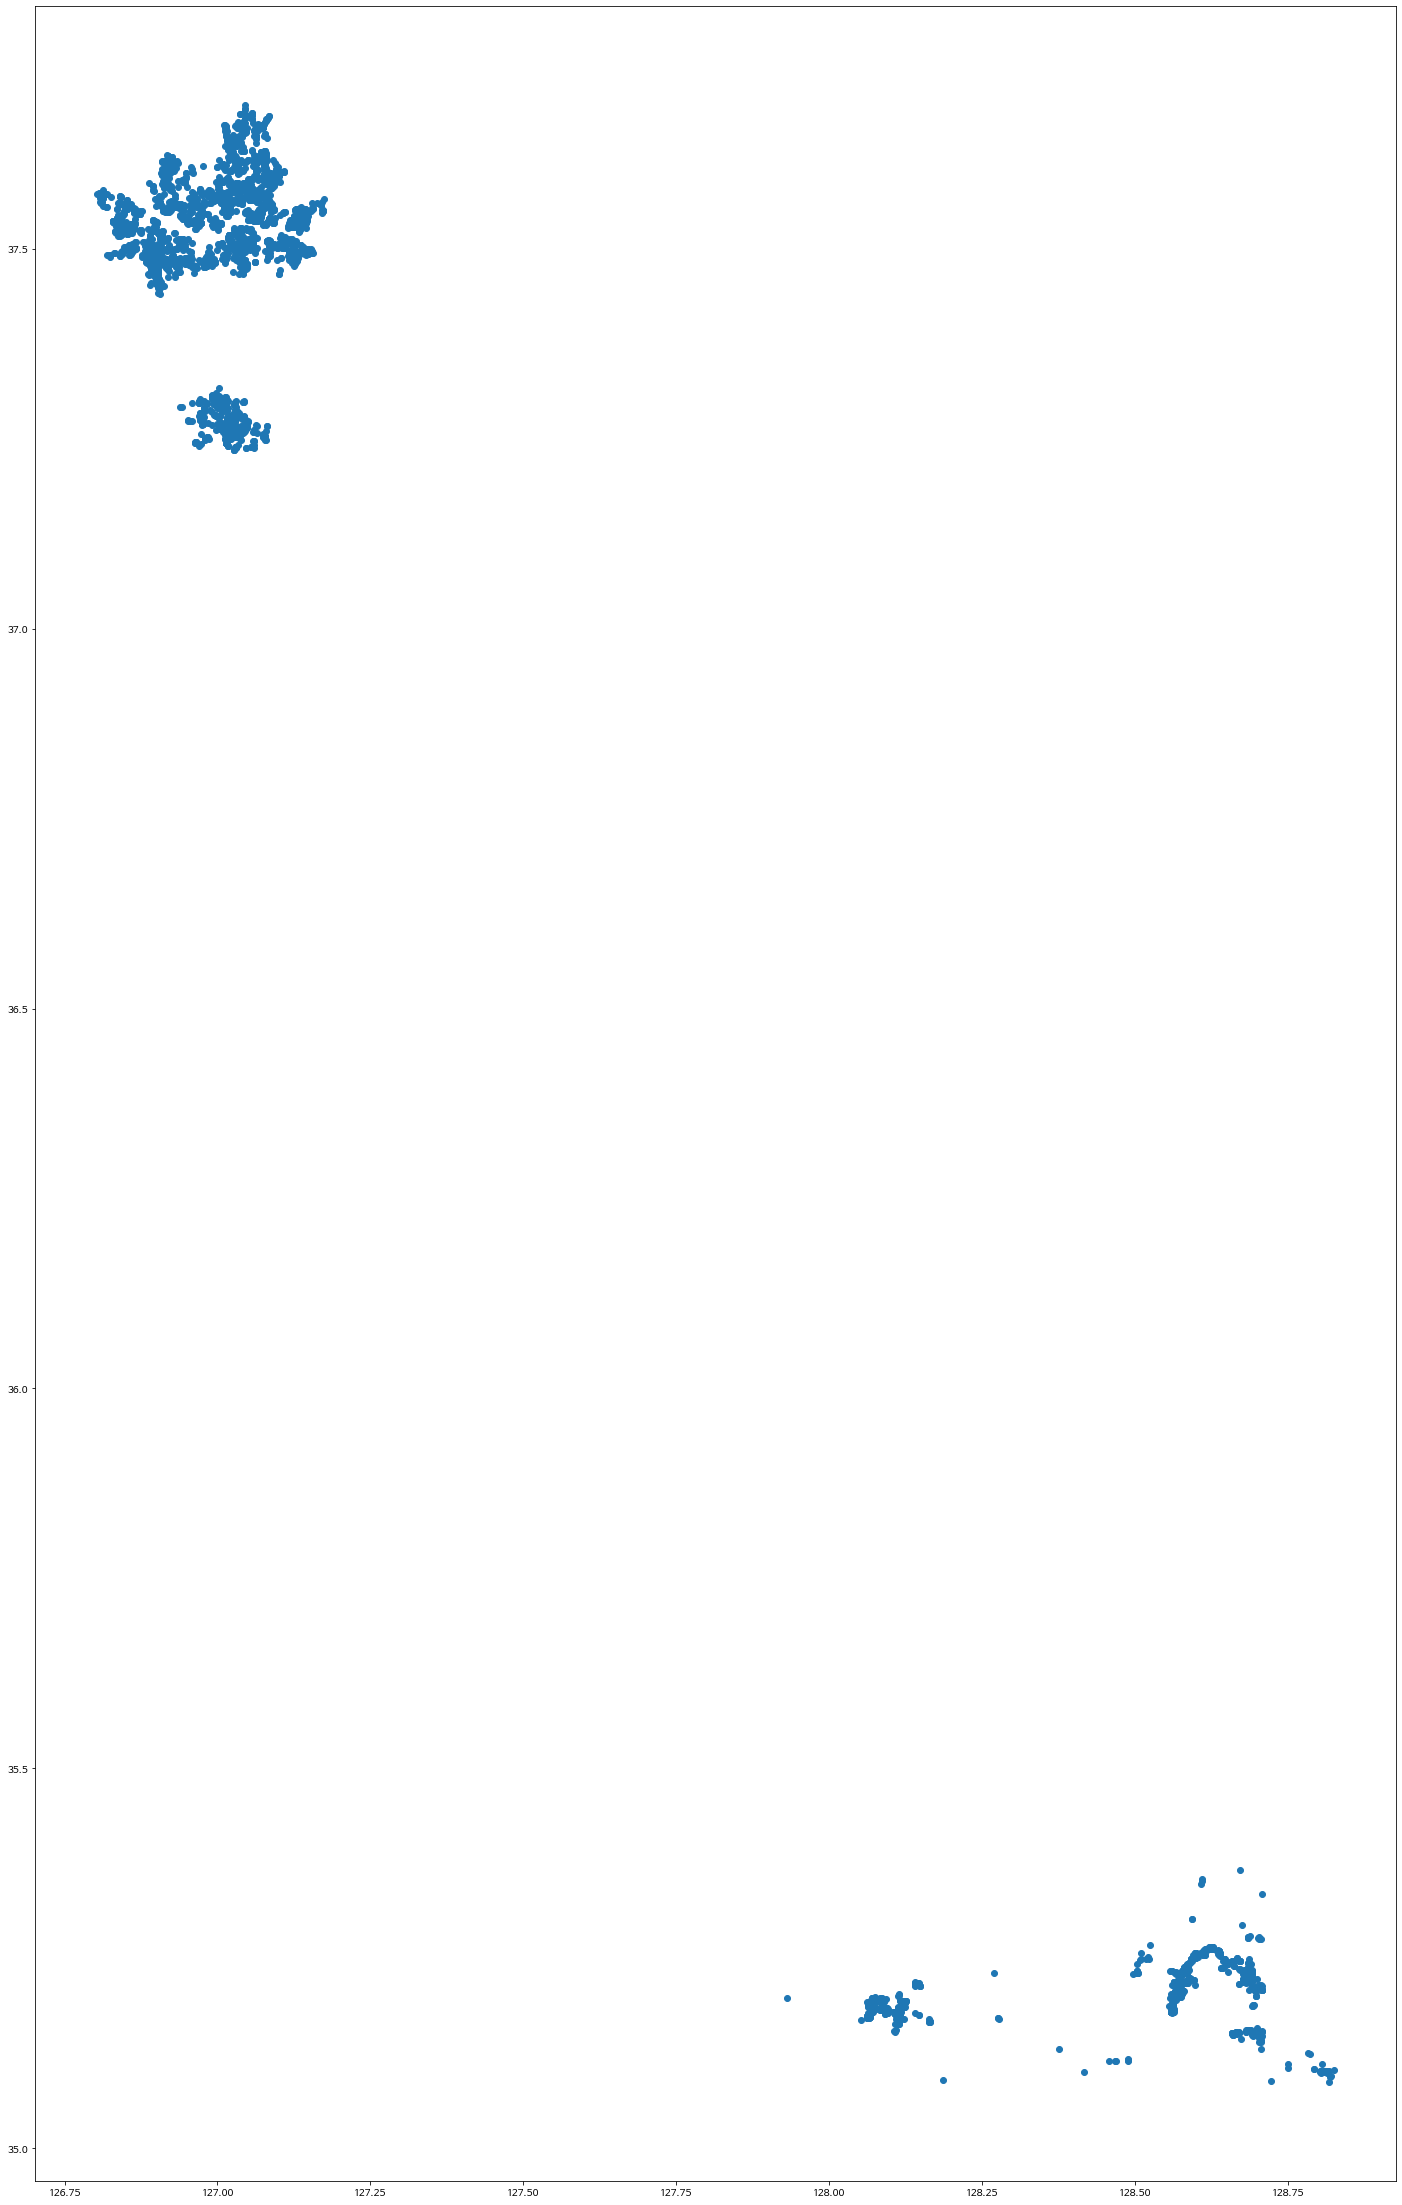

In [87]:
adult_ent.plot()

In [51]:
adult_ent_location_data = [[row["LAT"], row["LON"]] for _, row in adult_ent.iterrows()]

#### 유흥업소와 관련되있을법한 범죄 사례 위치 정보 저장

위도, 경도 정보없이 그릴 수 있을 지 찾아보기 -> 'gid' 활용?

In [60]:
suwon_report.head()

,case_type,rec_date,rec_time,arrival_date,gid,name,psname
0,비상벨,20200101,183945',NaN,다사56aa19ab,고등파출소,수원서부경찰서
1,기타_타기관,20200101,012615',20200101014135.0,다사58ab18ba,인계파출소,수원남부경찰서
2,폭력,20200101,005151',20200101005314.0,다사56bb21aa,화서문지구대,수원중부경찰서
3,소음,20200101,012608',20200101013131.0,다사57aa17ba,세류지구대,수원남부경찰서
4,분실습득,20200101,014719',NaN,다사59bb21aa,광교지구대,수원남부경찰서


In [62]:
drunk_suwon_report = suwon_report.loc[suwon_report['case_type'] == '주취자']
drunk_suwon_report

,case_type,rec_date,rec_time,arrival_date,gid,name,psname
23,주취자,20200101,002559',20200101003054.0,다사57aa20aa,행궁파출소,수원중부경찰서
29,주취자,20200101,014333',20200101014730.0,다사58ba20aa,동부파출소,수원중부경찰서
50,주취자,20200101,014525',20200101015334.0,다사55bb18bb,매산지구대,수원서부경찰서
56,주취자,20200101,011127',20200101011140.0,다사57ab19ba,행궁파출소,수원중부경찰서
67,주취자,20200101,015202',20200101015212.0,다사57aa19ba,행궁파출소,수원중부경찰서
...,...,...,...,...,...,...,...
223637,주취자,20201219,023743',20201219024132,다사54ba23ab,노송지구대,수원중부경찰서
223657,주취자,20201226,214302',20201226214903,다사55aa23aa,노송지구대,수원중부경찰서
223736,주취자,20201229,194639',20201229195019,다사55aa23aa,노송지구대,수원중부경찰서
223737,주취자,20201230,185926',20201230192657,다사54aa24aa,노송지구대,수원중부경찰서


In [53]:
# 수원시 중심부 위도, 경도
center = [37.264, 127.029]

map = folium.Map(
    location=center,
    tiles="Stamen Terrain",
    zoom_start=12,
)

In [ ]:
fg = folium.FeatureGroup(name="groups")
map.add_child(fd)

adult_ent = plugins.FeatureGroupSubGroup(fg, "adult_ent_density")
map.add_child(adult_ent)



In [55]:
plugins.HeatMap(adult_ent_location_data).add_to(map)

In [56]:
map

### 수원시 표준격자

In [66]:
GetCompasData('SBJ_2109_001', '32', '32.수원시_표준격자(250M_x_250M).geojson')

In [68]:
suwon_grid = gpd.read_file('32.수원시_표준격자(250M_x_250M).geojson')

In [69]:
suwon_grid.head()

,gid,geometry
0,다사49aa19ab,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ..."
1,다사49aa19ba,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ..."
2,다사49aa20aa,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ..."
3,다사49ab18ab,"MULTIPOLYGON (((126.92766 37.26177, 126.92764 ..."
4,다사49ab18ba,"MULTIPOLYGON (((126.92764 37.26402, 126.92762 ..."


In [82]:
sample_multipolygon = suwon_grid['geometry'][0]

In [84]:
for polygon in sample_multipolygon:
    print(polygon.exterior.coords[:-1])

[(126.92476861910082, 37.27076573094027), (126.92475147461319, 37.27301912088102), (126.92757119152385, 37.27303278916454), (126.92758825198494, 37.27077939811534)]


<AxesSubplot:>

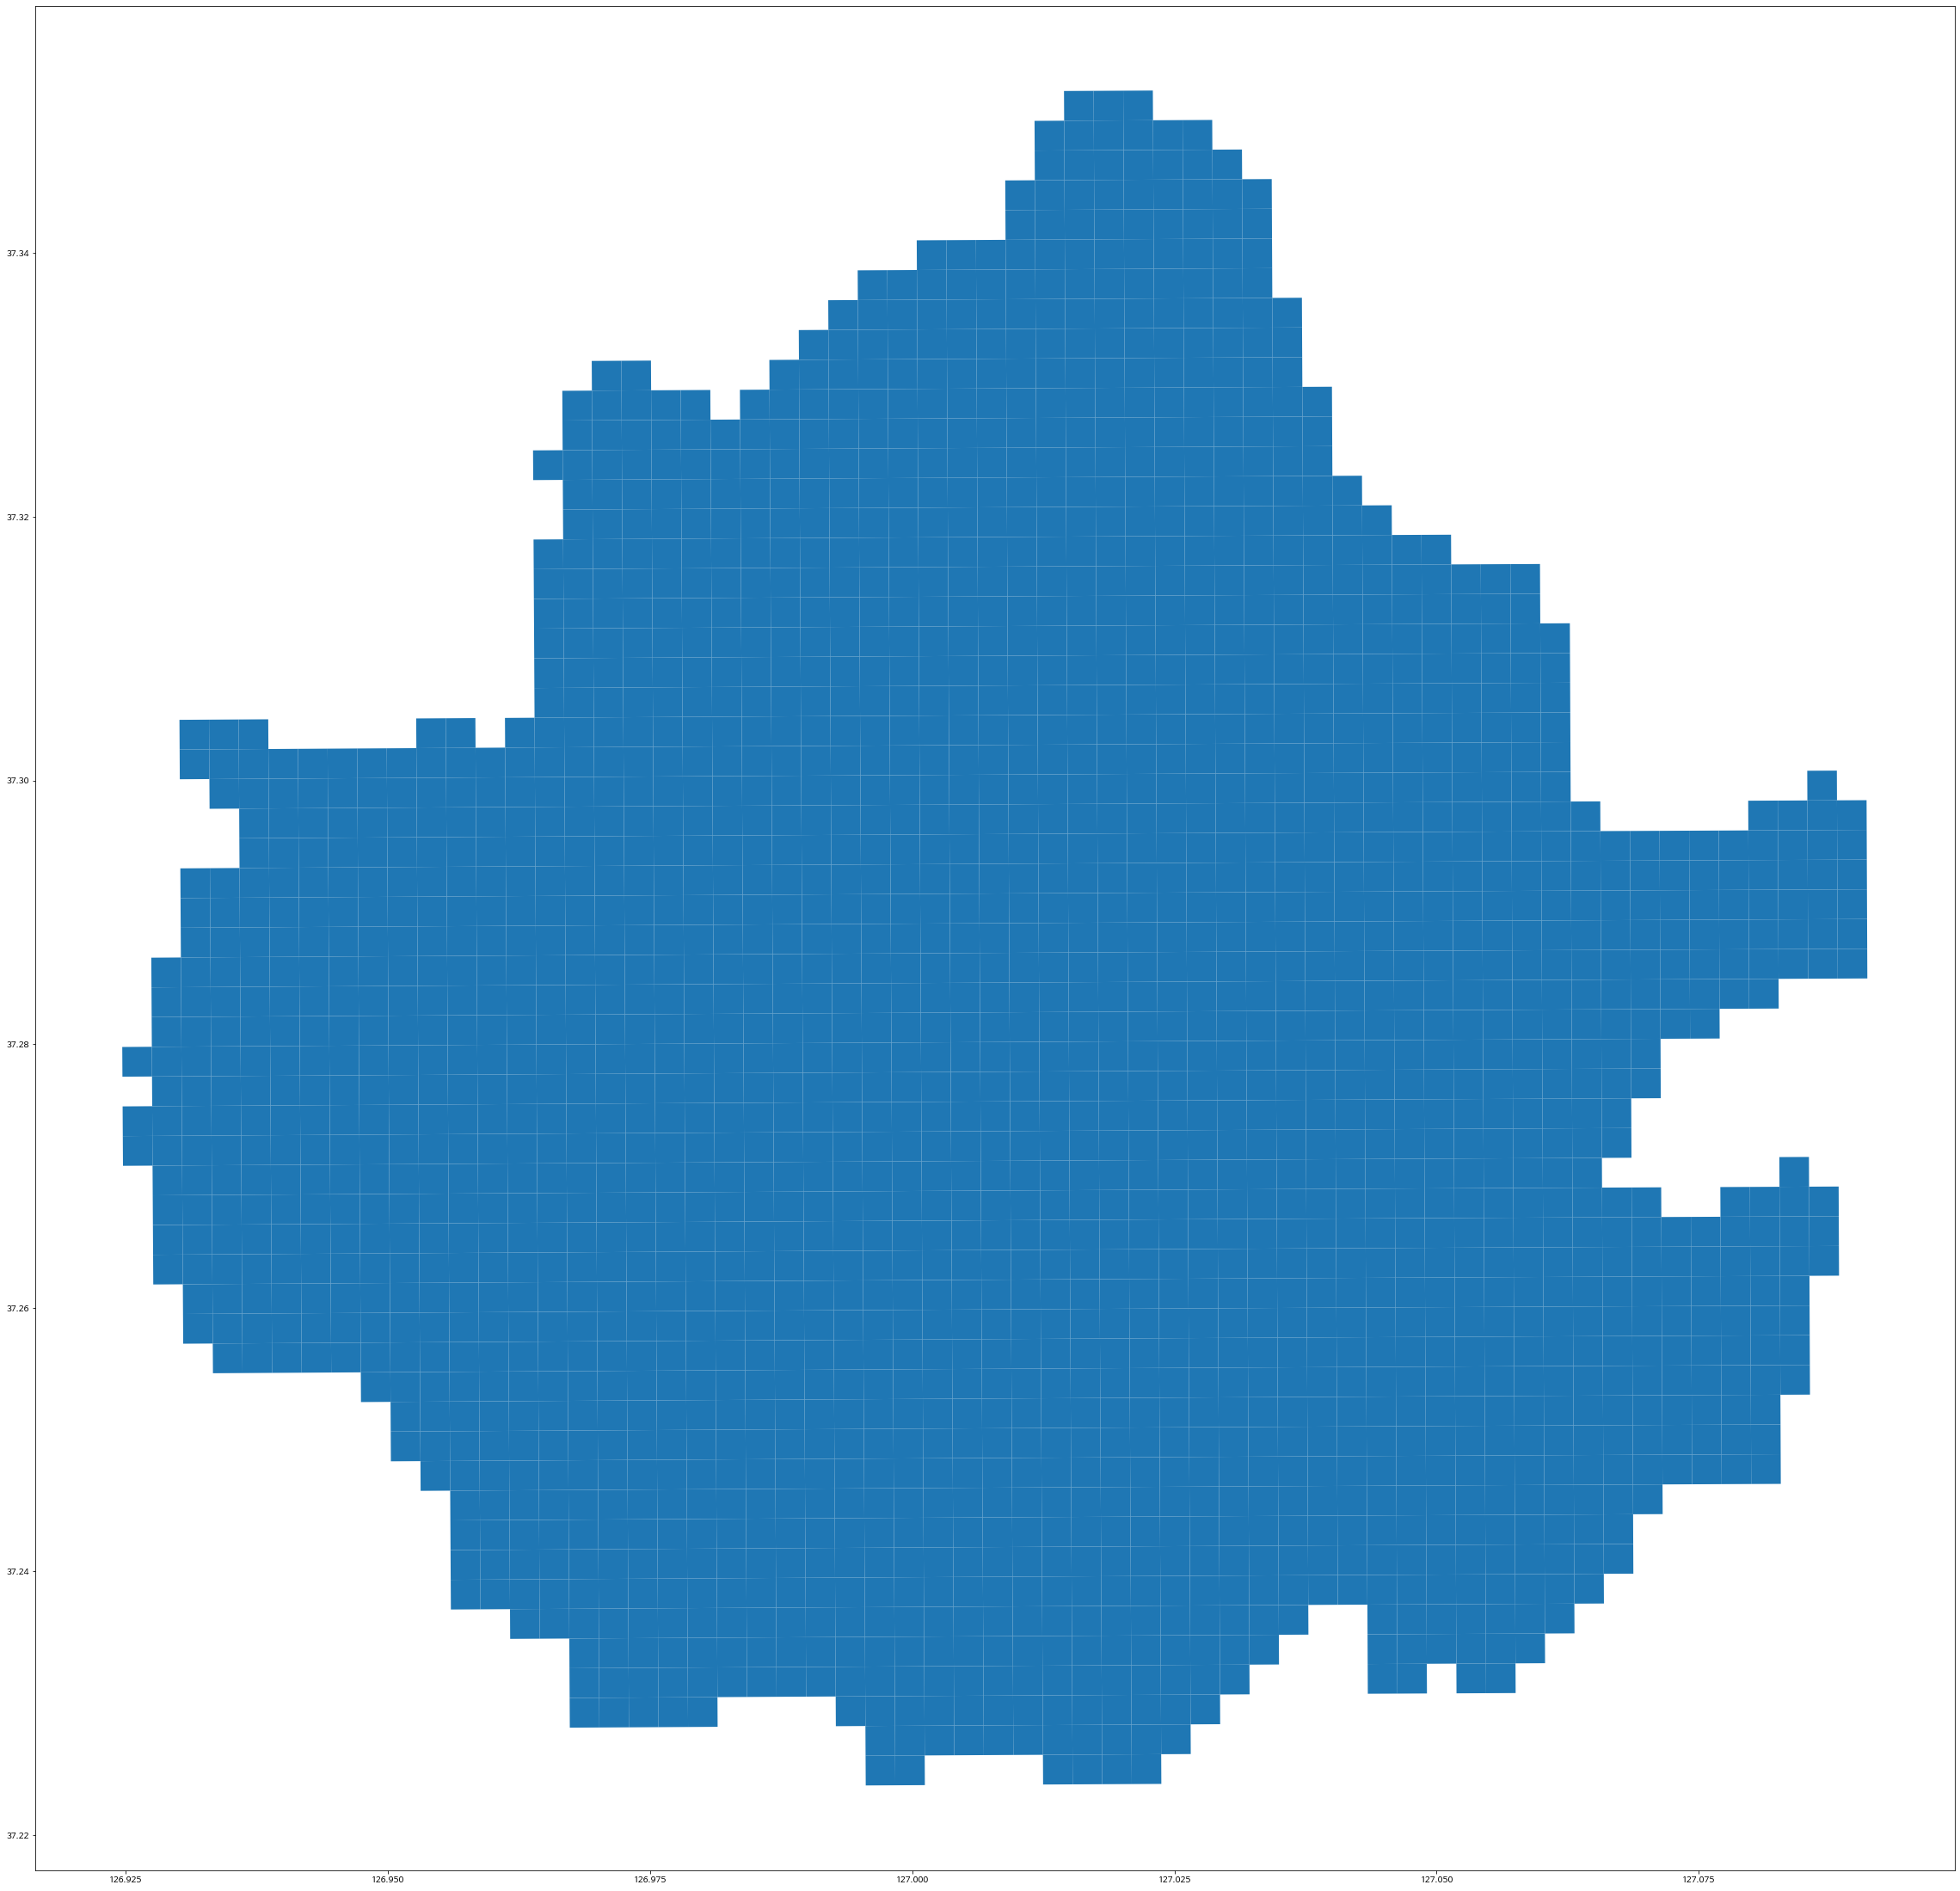

In [86]:
suwon_grid.plot()

---

## 4개시도_주택노후도

In [3]:
GetCompasData('SBJ_2109_001', '7', '7.4개시도_주택노후도.geojson')
house_det = gpd.read_file('7.4개시도_주택노후도.geojson')

In [5]:
house_det.head()

,ORG_GID,BLD_NM,DONG_NM,PNU,STRCT_NM,USE_NM,USEAPR_DAY,OLD_YEAR,OLD_LEVEL,geometry
0,704627.0,None,None,1111017500107040000,기타강구조,단독주택,19910902,30.0,4.0,"MULTIPOLYGON (((127.02166 37.57731, 127.02165 ..."
1,704628.0,None,None,1111017500100560024,벽돌구조,단독주택,19670528,54.0,4.0,"MULTIPOLYGON (((127.01600 37.57725, 127.01596 ..."
2,704629.0,None,None,1111017500100560054,벽돌구조,단독주택,19621221,58.0,4.0,"MULTIPOLYGON (((127.01633 37.57723, 127.01633 ..."
3,704630.0,None,None,1111017500100560053,벽돌구조,단독주택,19790601,42.0,4.0,"MULTIPOLYGON (((127.01651 37.57717, 127.01646 ..."
4,704632.0,None,None,1111016500100280041,철근콘크리트구조,제2종근린생활시설,19940425,27.0,3.0,"MULTIPOLYGON (((127.00532 37.57728, 127.00534 ..."


PNU코드의 구성은 [시도:2]-[시군구:3]-[읍면동:3]-[리:2]-[필지구분:1]-[본번:4]-[부번:4]로 이뤄져있습니다.

[참고링크](http://www.gisdeveloper.co.kr/?p=1562)

In [33]:
len(house_det)

754264

In [32]:
print(sum(house_det["PNU"].str.startswith('11'))) ## 서울

549113


In [39]:
print(sum(house_det["PNU"].str.startswith('41'))) ## 수원

63417


In [43]:
print(sum(house_det["PNU"].str.startswith('4812'))) ## 창원

95227


In [45]:
print(sum(house_det["PNU"].str.startswith('4817'))) ## 진주

46507


창원시 데이터만 뽑아서 사용해보겠습니다.

In [49]:
changwon_house_det = house_det.loc[house_det["PNU"].str.startswith('4812')]

In [48]:
changwon_house_det.head()

,ORG_GID,BLD_NM,DONG_NM,PNU,STRCT_NM,USE_NM,USEAPR_DAY,OLD_YEAR,OLD_LEVEL,geometry
612530,13085568.0,None,None,4812915900100330004,None,None,19890120,32.0,4.0,"MULTIPOLYGON (((128.77625 35.12810, 128.77626 ..."
612531,13085571.0,None,None,4812915900100380000,None,None,20020518,19.0,2.0,"MULTIPOLYGON (((128.77638 35.12838, 128.77639 ..."
612532,13085586.0,None,None,4812915900100220016,조적구조,단독주택,19891107,31.0,4.0,"MULTIPOLYGON (((128.77650 35.12758, 128.77665 ..."
612533,13085605.0,None,None,4812915900100190000,None,None,19930524,28.0,3.0,"MULTIPOLYGON (((128.77596 35.12724, 128.77596 ..."
612534,13085613.0,None,None,4812915900100210002,None,None,19940721,27.0,3.0,"MULTIPOLYGON (((128.77596 35.12763, 128.77595 ..."


In [53]:
changwon_house_det.isnull().sum()

ORG_GID           0
BLD_NM        81737
DONG_NM       82553
PNU               0
STRCT_NM       8609
USE_NM         8630
USEAPR_DAY        0
OLD_YEAR          0
OLD_LEVEL         0
geometry          0
dtype: int64

결측치가 많은 컬럼들이 존재합니다. BLD_NM, DONG_BM, STRCT_NM, USE_NM이 결측치가 많이 있습니다. 해당 컬럼들의 결측치가 분석에 큰 영향을 끼칠 것 같지는 않습니다. 데이터에서 건물 연한, 노후도, geometry 정보만 있어도 어느정도 분석을 할 수 있을 것 같습니다.

우선 간단하게 건물 노후도, geometry 정보만 가진 데이터를 만들어보겠습니다.

In [54]:
changwon_house_det_geo = changwon_house_det[['OLD_LEVEL', 'geometry']].copy()
changwon_house_det_geo.head()

,OLD_LEVEL,geometry
612530,4.0,"MULTIPOLYGON (((128.77625 35.12810, 128.77626 ..."
612531,2.0,"MULTIPOLYGON (((128.77638 35.12838, 128.77639 ..."
612532,4.0,"MULTIPOLYGON (((128.77650 35.12758, 128.77665 ..."
612533,3.0,"MULTIPOLYGON (((128.77596 35.12724, 128.77596 ..."
612534,3.0,"MULTIPOLYGON (((128.77596 35.12763, 128.77595 ..."


In [58]:
# 창원시 중심부 위도, 경도
center = [35.234, 128.680]

map = folium.Map(
    location=center,
    zoom_start=12,
    prefer_canvas=True
)



In [59]:
for _, row in changwon_house_det_geo.iterrows():
    sim_geo = gpd.GeoSeries([row['geometry']]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function = lambda x : {'fillColor': 'orange'})
    folium.Popup(row['OLD_LEVEL']).add_to(geo_j)
    geo_j.add_to(map)


In [60]:
map